In [2]:
import pandas as pd
import numpy as np

df_raw = pd.read_csv('/Users/joezhou/Downloads/Boomscore 20251019.csv')


In [15]:
# data cleaninng

cols_to_numeric = [
    'Days on Market', 
    'Stock on Market %', 
    'Online Interest', 
]

for col in cols_to_numeric:
    df_raw[col] = pd.to_numeric(df_raw[col].replace('[^\d\.\-]', '', regex=True), errors='coerce')

# Convert percentage string columns to numeric (remove % and convert)
percent_cols = [
    'Vendor Discount',
    'Gross Rental Yield',
    'Auction Clearance Rate',
    'Vacancy Rates',
    'Data Quality'
]

for col in percent_cols:
    df_raw[col] = df_raw[col].replace('%', '', regex=True)
    df_raw[col] = pd.to_numeric(df_raw[col], errors='coerce')


df_raw['Post code'] = df_raw['Post code'].astype(str)

df_raw.dtypes


Post code                  object
Locality                   object
State                      object
Dwelling Type              object
Boomscore                   int64
Typical value             float64
Days on Market            float64
Vendor Discount           float64
Auction Clearance Rate    float64
Gross Rental Yield        float64
Stock on Market %         float64
Online Interest           float64
Vacancy Rates             float64
Proportions of Renters      int64
Data Quality                int64
dtype: object

In [25]:
# encode data

# Create a copy to avoid modifying original DataFrame
encoded_df = df_raw.copy()
encoded_df['Dwelling Type'] = encoded_df['Dwelling Type'].map(lambda x: 'Dwelling_unit' if x == 'U' else ('Dwelling_house' if x == 'H' else x))
encoded_df['Typical value'] = encoded_df['Typical value'].replace('[\$,]', '', regex=True).astype(float)

# One-hot encode 'State' and 'Dwelling Type' (new columns only)
dummies = pd.get_dummies(encoded_df[['State', 'Dwelling Type']], dtype=int)

# Concatenate original DataFrame with encoded columns
df_encoded = pd.concat([encoded_df, dummies], axis=1)

# Add normalized typical value
df_encoded['Typical_value_norm'] = (df_encoded['Typical value'] - df_encoded['Typical value'].min()) / (df_encoded['Typical value'].max() - df_encoded['Typical value'].min())

df_encoded.head()
# ...existing code...


,Post code,Locality,State,Dwelling Type,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,...,State_NSW,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm
0,4113,RUNCORN,QLD,Dwelling_unit,73,458834.0,18.0,-2.0,77.0,4.7,...,0,0,1,0,0,0,0,0,1,0.044689
1,3156,FERNTREE GULLY,VIC,Dwelling_unit,73,600778.0,19.0,NaN,77.0,4.3,...,0,0,0,0,0,1,0,0,1,0.064543
2,2203,DULWICH HILL,NSW,Dwelling_house,73,1634500.0,14.0,NaN,81.0,NaN,...,1,0,0,0,0,0,0,1,0,0.209131
3,2085,BELROSE,NSW,Dwelling_house,72,2174750.0,36.0,-3.0,82.0,3.1,...,1,0,0,0,0,0,0,1,0,0.284697
4,2171,CECIL HILLS,NSW,Dwelling_house,71,1122250.0,22.0,-7.0,73.0,2.8,...,1,0,0,0,0,0,0,1,0,0.137482


Top 20 highest correlating variable pairs:
Dwelling Type_Dwelling_house  Proportions of Renters          0.822933
Proportions of Renters        Dwelling Type_Dwelling_house    0.822933
                              Dwelling Type_Dwelling_unit     0.822933
Dwelling Type_Dwelling_unit   Proportions of Renters          0.822933
Gross Rental Yield            Typical_value_norm              0.717999
Typical_value_norm            Gross Rental Yield              0.717999
Typical value                 Gross Rental Yield              0.717999
Gross Rental Yield            Typical value                   0.717999
Auction Clearance Rate        Boomscore                       0.624264
Boomscore                     Auction Clearance Rate          0.624264
Proportions of Renters        Gross Rental Yield              0.570234
Gross Rental Yield            Proportions of Renters          0.570234
                              Dwelling Type_Dwelling_unit     0.530949
Dwelling Type_Dwelling_unit   Gros

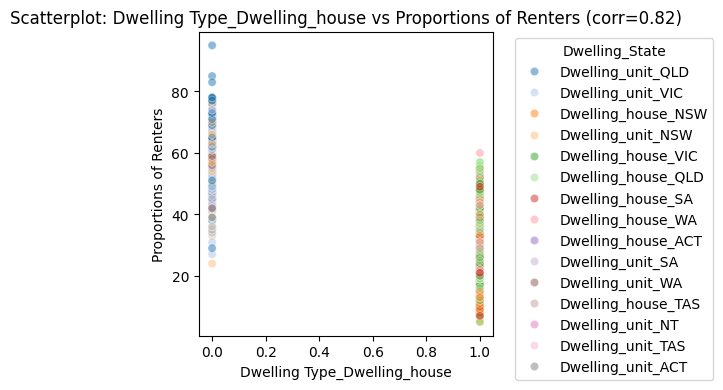

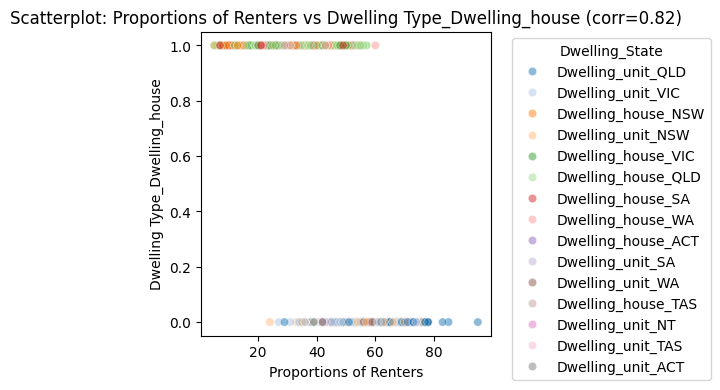

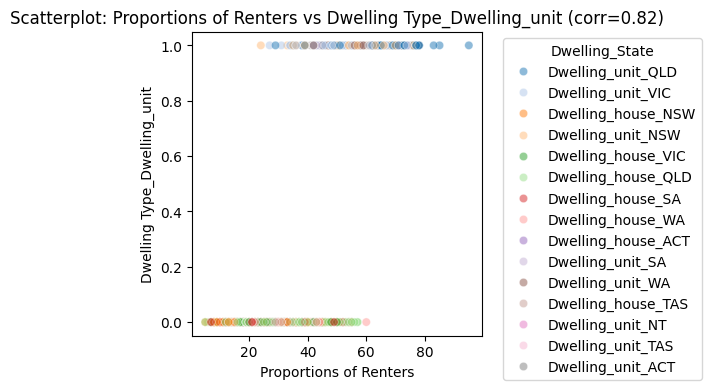

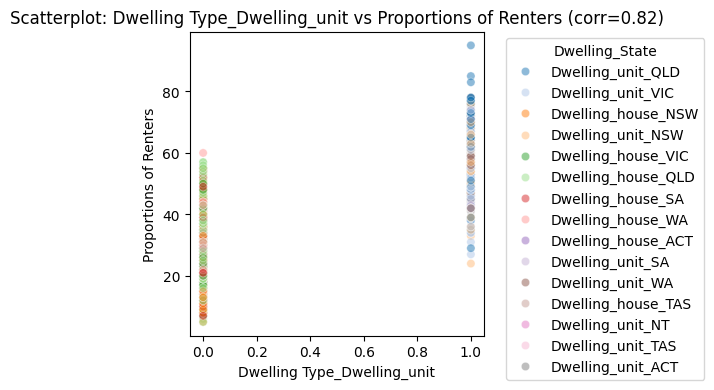

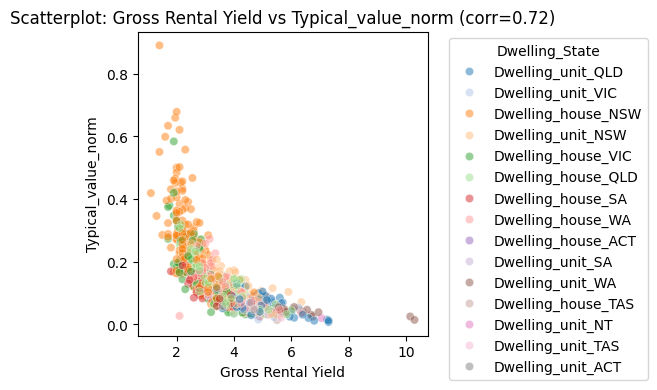

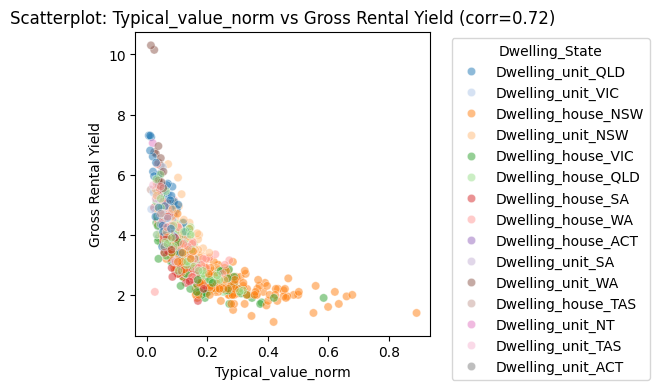

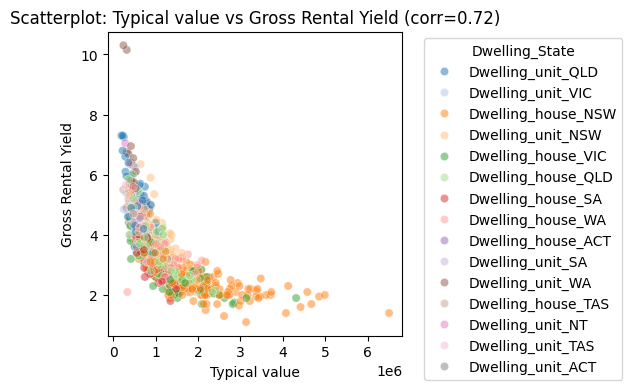

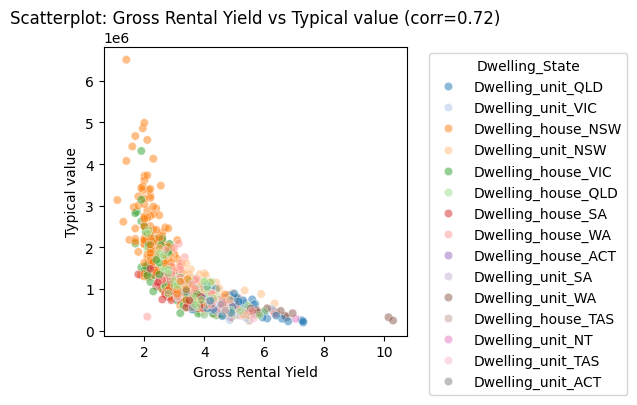

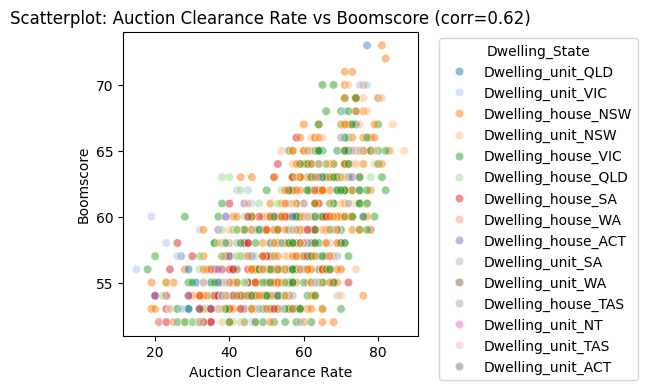

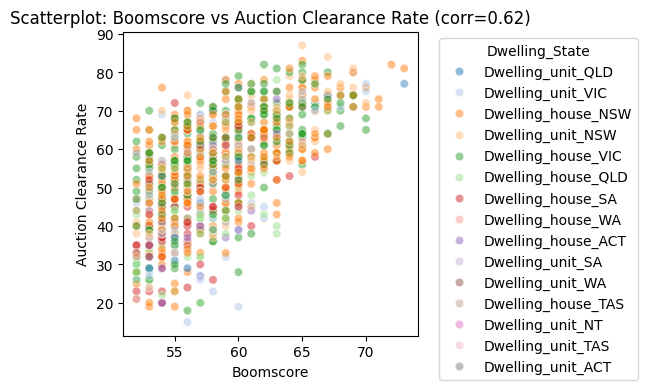

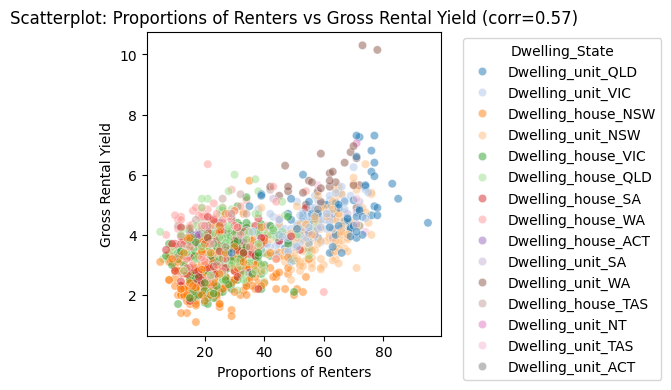

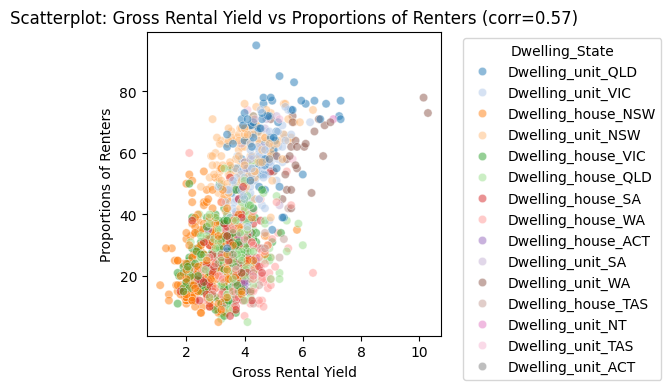

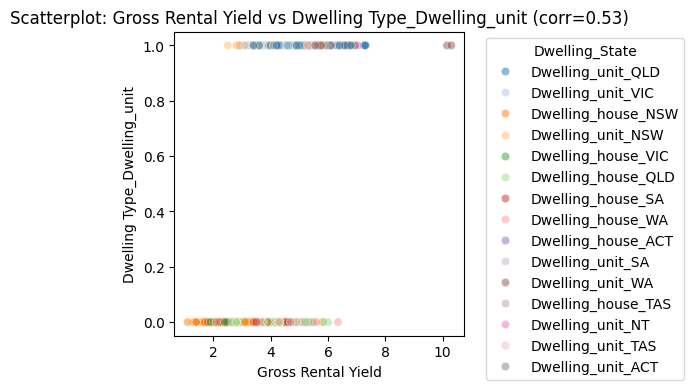

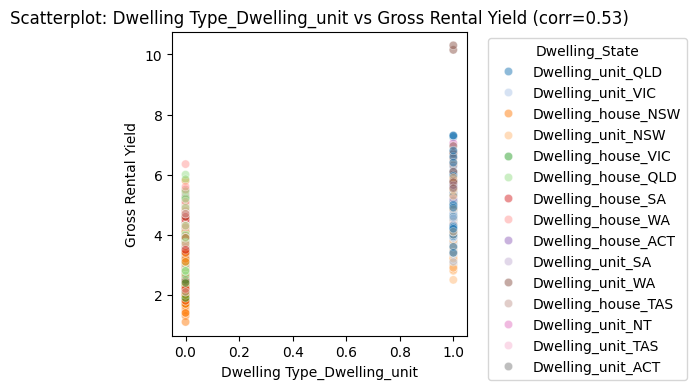

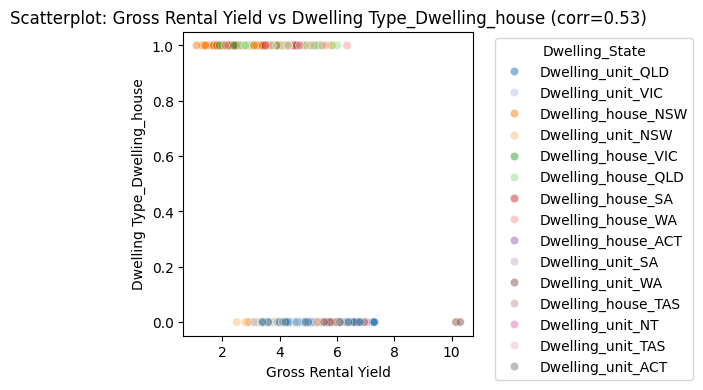

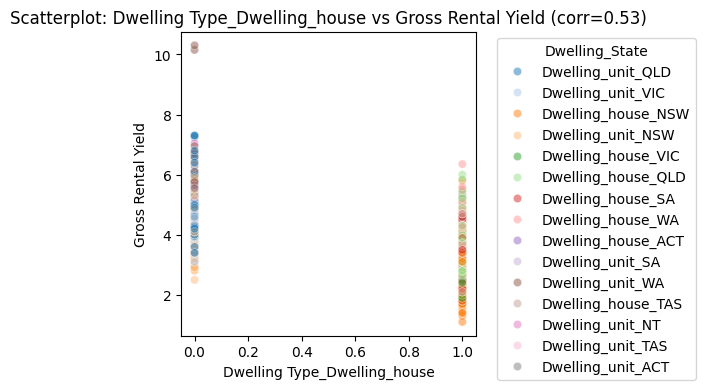

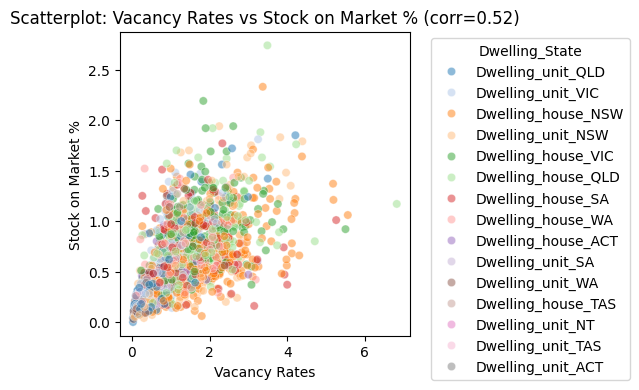

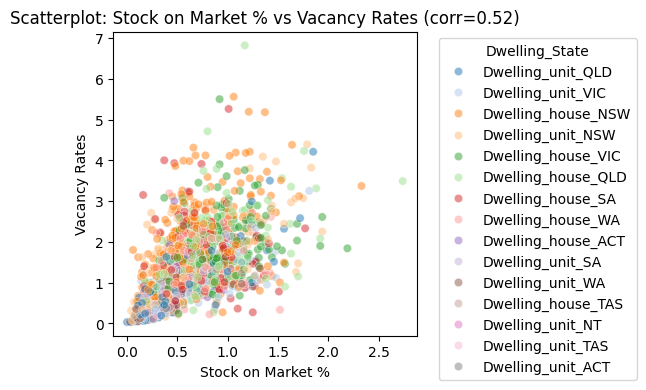

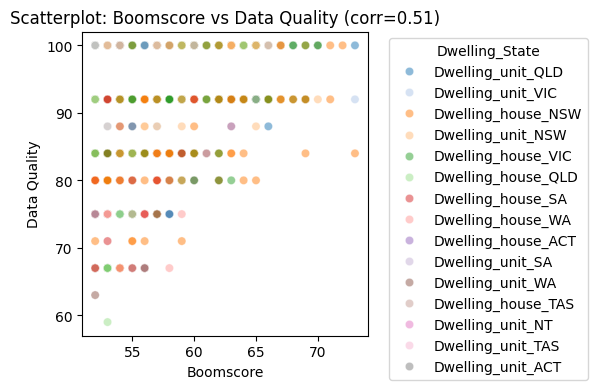

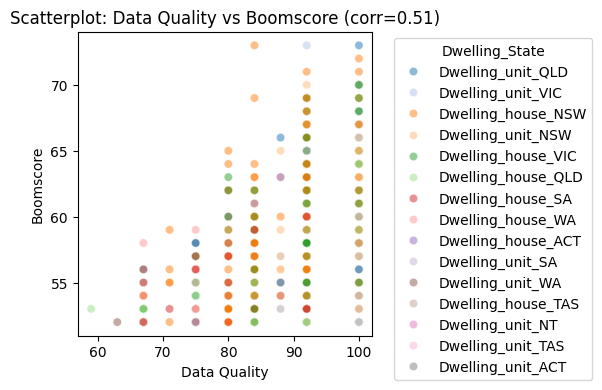

In [29]:
# Find and visualize the top 20 highest correlating variable pairs in df_encoded

import matplotlib.pyplot as plt
import seaborn as sns

# Create a combined column for coloring
if 'Dwelling_State' not in df_encoded.columns:
    df_encoded['Dwelling_State'] = df_encoded['Dwelling Type'].astype(str) + '_' + df_encoded['State'].astype(str)

corr_matrix = df_encoded.corr(numeric_only=True)
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
# Remove self-correlation
corr_pairs = corr_pairs[corr_pairs < 1]
# Drop duplicate pairs
corr_pairs = corr_pairs[~corr_pairs.index.duplicated()]
# Show top 20 highest correlations
top_corr = corr_pairs.head(20)
print("Top 20 highest correlating variable pairs:")
print(top_corr)

# Plot scatterplots for each of the top 20 correlated pairs, colored by Dwelling_State
for (var1, var2), corr_value in top_corr.items():
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df_encoded[var1], y=df_encoded[var2], hue=df_encoded['Dwelling_State'], alpha=0.5, palette='tab20')
    plt.title(f'Scatterplot: {var1} vs {var2} (corr={corr_value:.2f})')
    plt.xlabel(var1)
    plt.ylabel(var2)
    plt.legend(title='Dwelling_State', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

,Post code,Locality,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,...,State_NSW,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm
count,1276.000000,1276,1276.000000,1.276000e+03,1275.000000,594.000000,963.000000,1167.000000,1276.000000,1200.000000,...,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
unique,NaN,998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,PADDINGTON,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,3428.902821,NaN,57.250000,1.057249e+06,33.231373,-4.597643,55.175493,3.650214,0.694953,159.426667,...,0.364420,0.000784,0.157524,0.095611,0.010972,0.275078,0.077586,0.706113,0.293887,0.128390
std,1302.453600,NaN,4.421627,6.923801e+05,18.127378,1.528171,14.110175,1.036345,0.375459,92.135328,...,0.481456,0.027995,0.364436,0.294173,0.104211,0.446729,0.267624,0.455719,0.455719,0.096844
min,810.000000,NaN,52.000000,1.393330e+05,1.000000,-13.000000,15.000000,1.100000,0.000000,3.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2209.750000,NaN,54.000000,6.256562e+05,19.000000,-5.000000,45.000000,2.900000,0.420000,97.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.068023
50%,3124.000000,NaN,56.000000,8.437080e+05,31.000000,-4.000000,57.000000,3.650000,0.655000,140.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.098522
75%,4216.000000,NaN,60.000000,1.287555e+06,45.000000,-4.000000,66.000000,4.250000,0.920000,201.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.160604


Missing values per column:
Post code                         0
Locality                          0
Boomscore                         0
Typical value                     0
Days on Market                    1
Vendor Discount                 682
Auction Clearance Rate          313
Gross Rental Yield              109
Stock on Market %                 0
Online Interest                  76
Vacancy Rates                     2
Proportions of Renters            0
Data Quality                      0
State_ACT                         0
State_NSW                         0
State_NT                          0
State_QLD                         0
State_SA                          0
State_TAS                         0
State_VIC                         0
State_WA                          0
Dwelling Type_Dwelling_house      0
Dwelling Type_Dwelling_unit       0
Typical_value_norm                0
dtype: int64


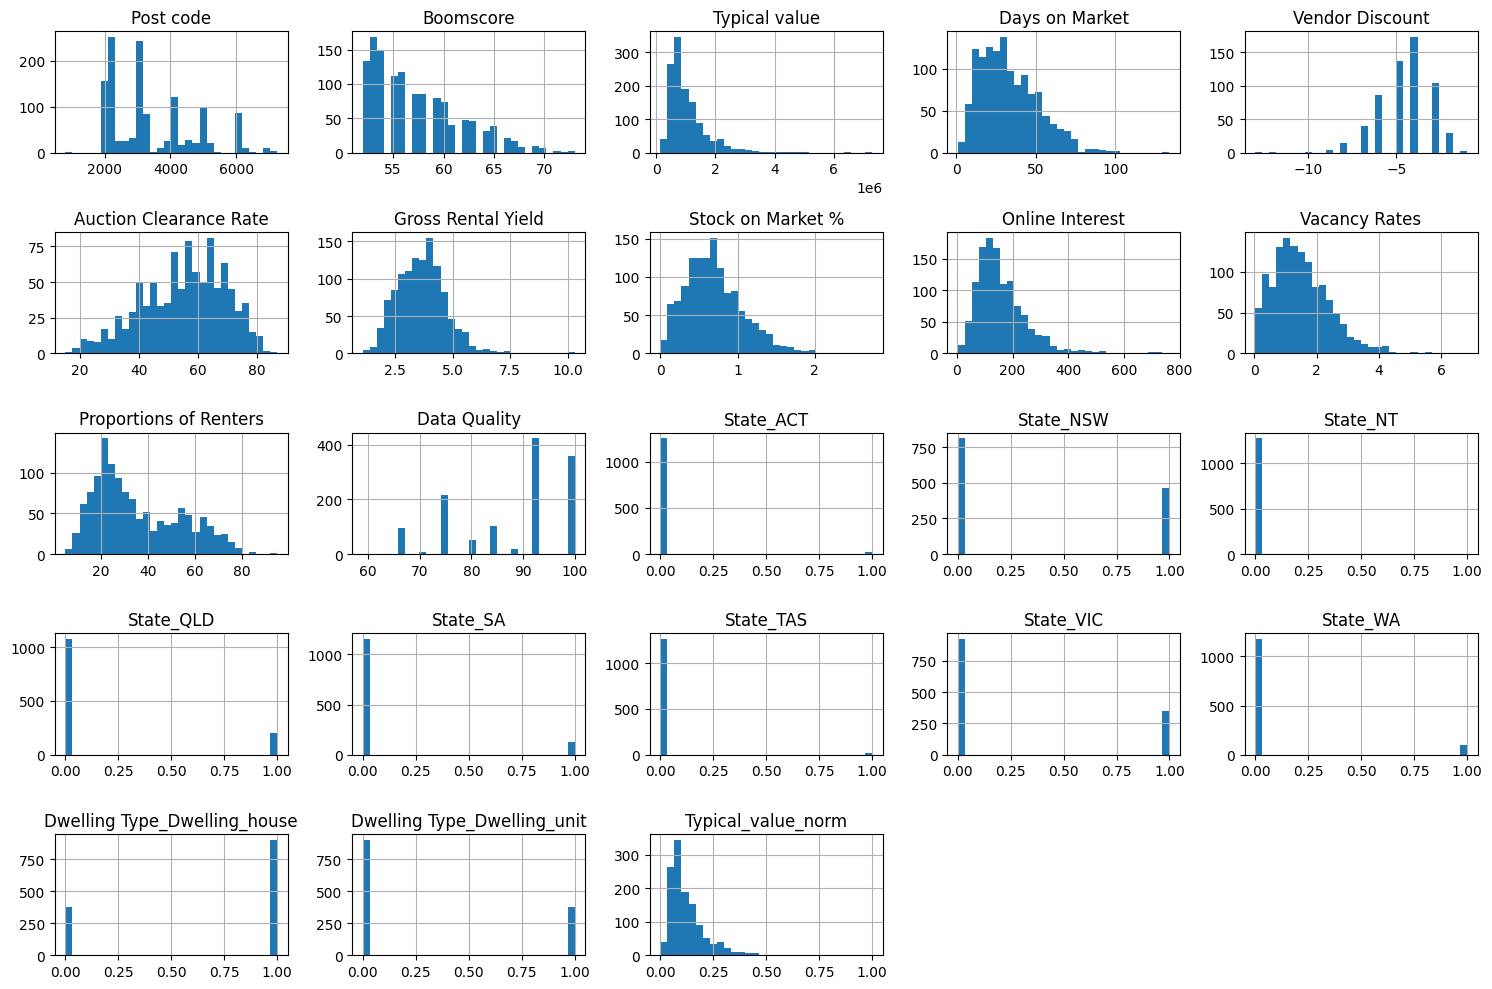

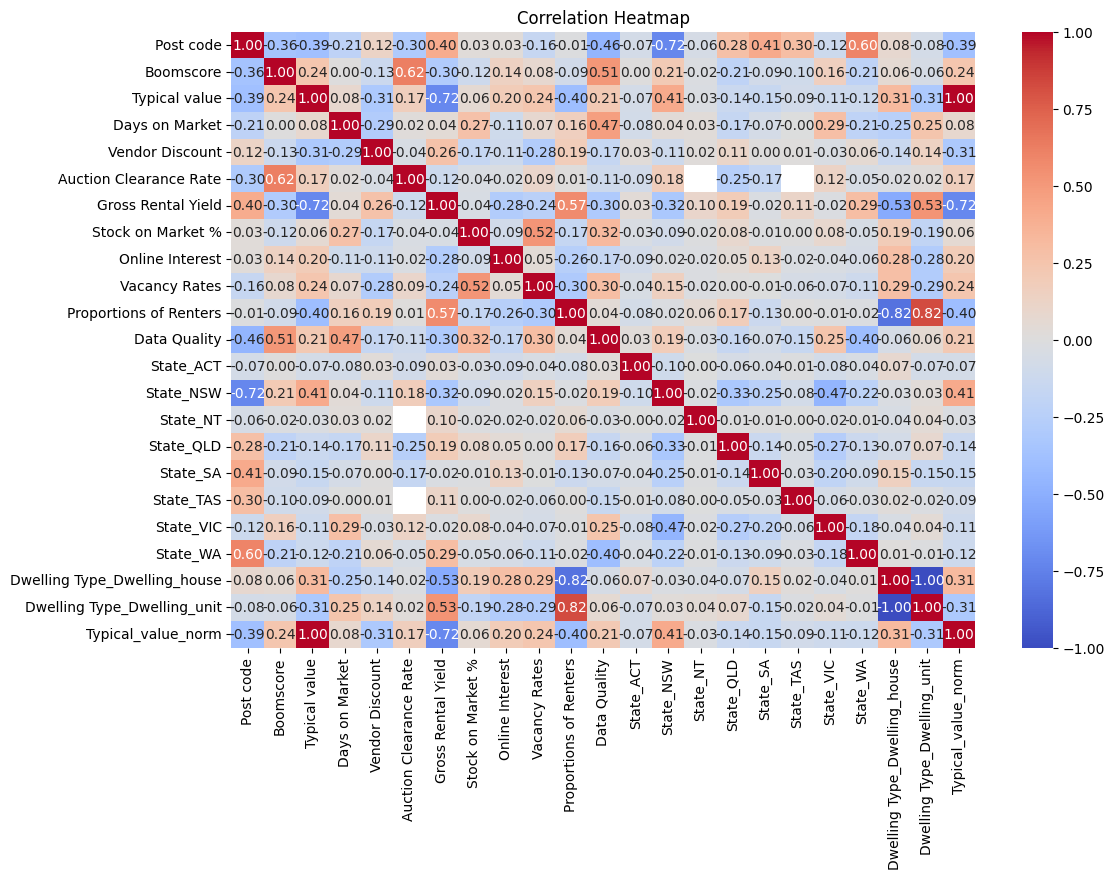

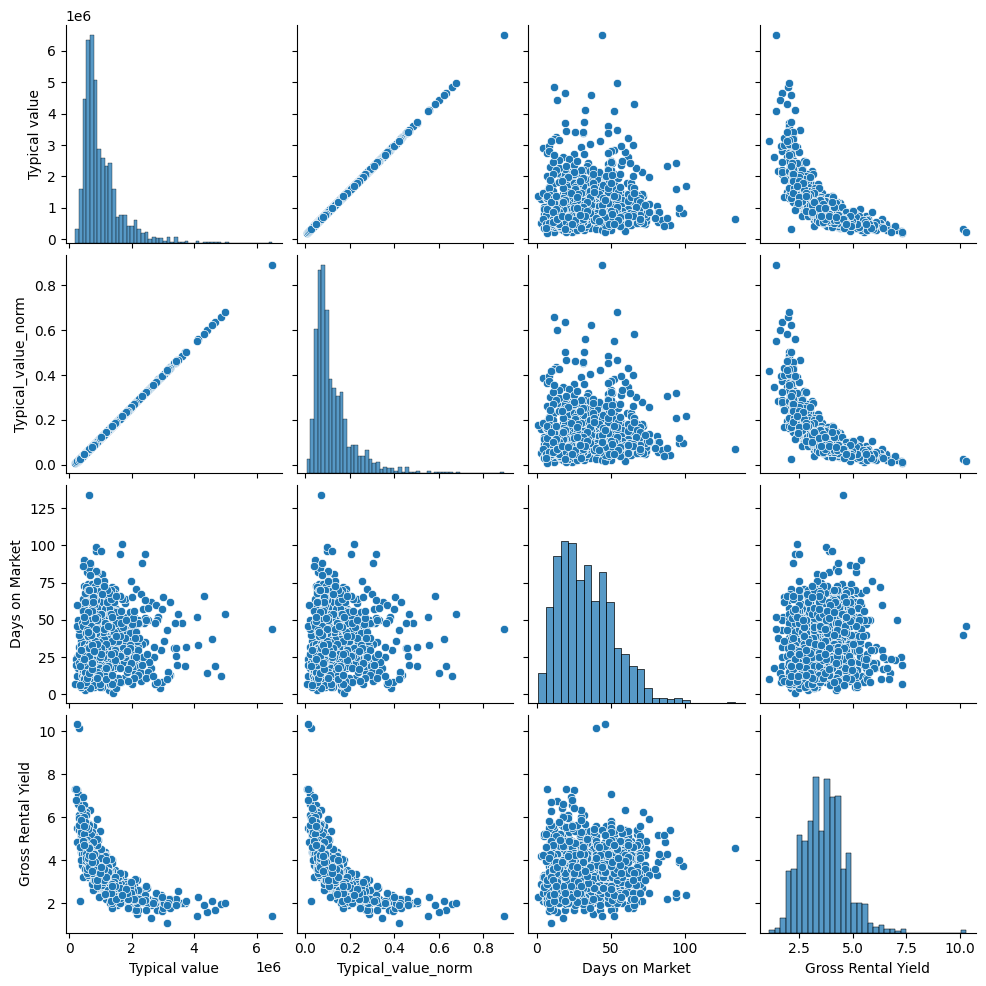

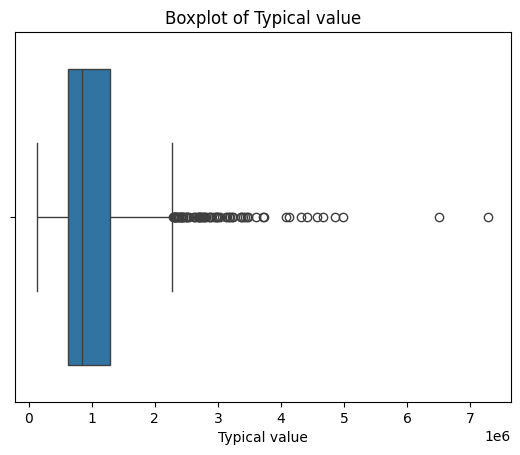

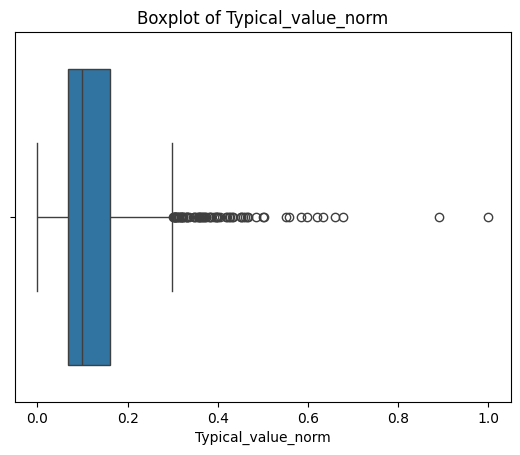

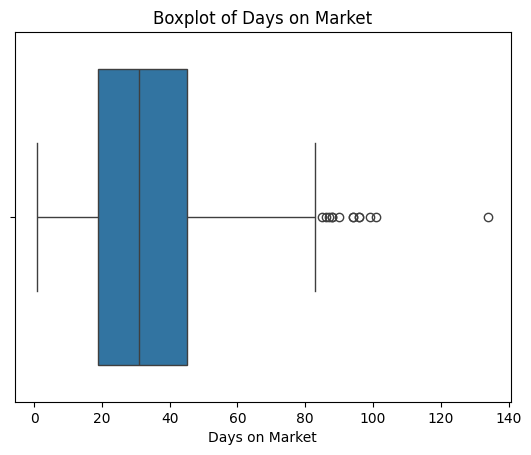

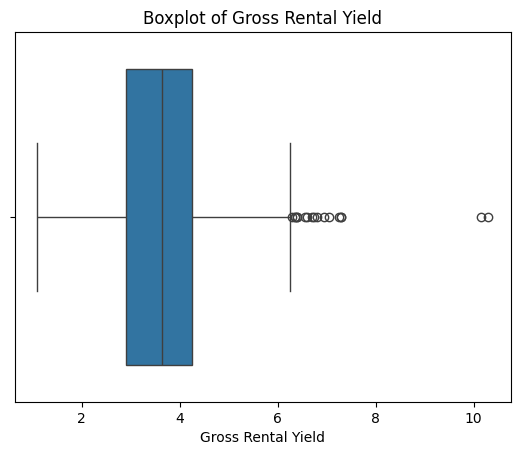

In [16]:
# Exploratory Data Analysis (EDA) for df_encoded

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Summary statistics
display(df_encoded.describe(include='all'))

# 2. Check for missing values
print("Missing values per column:")
print(df_encoded.isnull().sum())

# 3. Distribution plots for key numeric variables
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns
df_encoded[numeric_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

# 4. Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded[numeric_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 5. Pairplot for selected variables (if not too many)
selected = ['Typical value', 'Typical_value_norm', 'Days on Market', 'Gross Rental Yield']
selected = [col for col in selected if col in df_encoded.columns]
if len(selected) > 1:
    sns.pairplot(df_encoded[selected].dropna())
    plt.show()

# 6. Boxplots for outlier detection
for col in selected:
    plt.figure()
    sns.boxplot(x=df_encoded[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

# 7. Count plots for categorical variables (one-hot encoded)
categorical_cols = [col for col in df_encoded.columns if set(df_encoded[col].unique()) <= {0, 1} and col not in numeric_cols]
for col in categorical_cols:
    plt.figure()
    sns.countplot(x=df_encoded[col])
    plt.title(f'Countplot of {col}')
    plt.show()

ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

/Users/joezhou/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/joezhou/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/joezhou/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T
/Users/joezhou/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/joezhou/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/joezhou/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in 

Optimal number of clusters (by silhouette score): 7


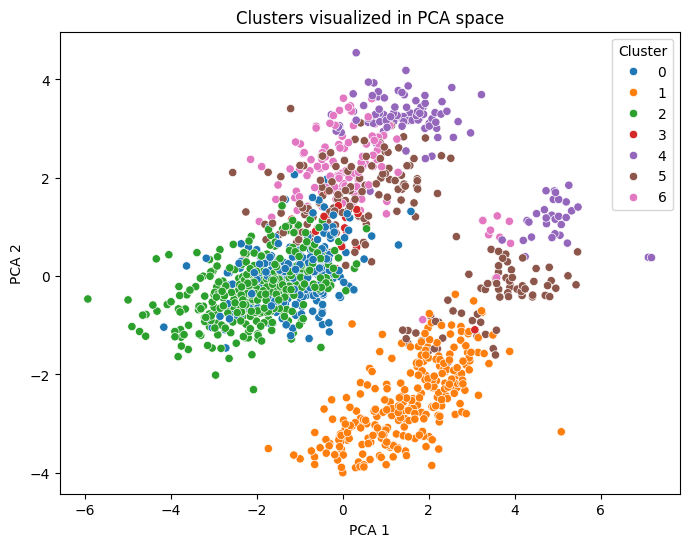

,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NSW,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm
cluster,,,,,,,,,,,,,,,,,,,,,
0,3171.476793,58.919831,1.084126e+06,37.253165,-4.942857,60.066372,3.199261,0.827426,175.627193,1.684430,...,0.000000,0.000000,0.000000,0.0,0.000000,1.00000,0.000000,1.000000,0.000000,0.132150
1,2601.574144,58.015209,7.831282e+05,46.296578,-4.587963,57.110599,4.185441,0.611901,114.514056,1.226692,...,0.551331,0.003802,0.011407,0.0,0.000000,0.43346,0.000000,0.000000,1.000000,0.090049
2,2211.675000,58.478125,1.660661e+06,30.078370,-5.077922,56.849498,2.769853,0.648969,175.020906,1.774107,...,1.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,1.000000,0.000000,0.212791
3,2739.478261,57.260870,6.858894e+05,22.260870,-4.250000,46.863636,3.911364,0.600870,89.882353,1.231304,...,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.956522,0.043478,0.076448
4,6225.893805,53.884956,7.376586e+05,21.902655,-4.365854,43.333333,4.646903,0.637345,140.937500,1.139204,...,0.000000,0.000000,0.000000,0.0,0.123894,0.00000,0.876106,0.734513,0.265487,0.083689
5,4276.308081,54.934343,8.423429e+05,26.151515,-4.298387,43.898990,4.080159,0.773485,170.433673,1.539747,...,0.000000,0.000000,1.000000,0.0,0.000000,0.00000,0.000000,0.641414,0.358586,0.098331
6,5069.237705,56.008197,7.280576e+05,29.549180,-4.588235,48.051546,3.572430,0.680902,196.450450,1.496942,...,0.000000,0.000000,0.000000,1.0,0.000000,0.00000,0.000000,0.918033,0.081967,0.082346


Cluster sizes:
cluster
2    320
1    263
0    237
5    198
6    122
4    113
3     23
Name: count, dtype: int64
Most frequent correlated variable pairs:
Proportions of Renters       Dwelling Type_Dwelling_house    0.822933
Dwelling Type_Dwelling_unit  Proportions of Renters          0.822933
Post code                    State_NSW                       0.719997
Typical_value_norm           Gross Rental Yield              0.717999
Typical value                Gross Rental Yield              0.717999
cluster                      Post code                       0.677497
                             State_VIC                       0.656813
Auction Clearance Rate       Boomscore                       0.624264
Post code                    State_WA                        0.596204
cluster                      State_SA                        0.572400
dtype: float64

Cluster 0 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,237.000000,237.000000,2.370000e+02,237.000000,70.000000,226.000000,203.000000,237.000000,228.000000,237.000000,...,237.0,237.0,237.0,237.0,237.0,237.0,237.0,237.0,237.000000,237.0
mean,3171.476793,58.919831,1.084126e+06,37.253165,-4.942857,60.066372,3.199261,0.827426,175.627193,1.684430,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.132150,0.0
std,202.593409,4.368355,5.580558e+05,17.358973,1.473296,12.003334,0.688834,0.327662,92.535630,0.731768,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.078056,0.0
min,3003.000000,52.000000,3.703750e+05,5.000000,-9.000000,18.000000,1.700000,0.180000,3.000000,0.240000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.032316,0.0
25%,3058.000000,55.000000,7.150000e+05,25.000000,-6.000000,54.000000,2.700000,0.590000,112.750000,1.150000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.080519,0.0
50%,3131.000000,59.000000,9.300000e+05,36.000000,-5.000000,62.000000,3.300000,0.800000,158.000000,1.590000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.110592,0.0
75%,3184.000000,62.000000,1.291625e+06,48.000000,-4.000000,69.000000,3.700000,0.990000,212.500000,2.060000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.161173,0.0
max,3977.000000,70.000000,4.315000e+06,101.000000,-2.000000,82.000000,5.250000,2.190000,570.000000,5.500000,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.584057,0.0



Cluster 1 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,263.000000,263.000000,2.630000e+02,263.000000,216.000000,217.000000,261.000000,263.000000,249.000000,263.000000,...,263.000000,263.000000,263.0,263.0,263.000000,263.0,263.0,263.0,263.000000,263.0
mean,2601.574144,58.015209,7.831282e+05,46.296578,-4.587963,57.110599,4.185441,0.611901,114.514056,1.226692,...,0.003802,0.011407,0.0,0.0,0.433460,0.0,0.0,1.0,0.090049,1.0
std,559.522924,4.756650,3.194664e+05,19.931645,1.391550,14.573464,0.693152,0.404972,70.227976,0.880555,...,0.061663,0.106394,0.0,0.0,0.496497,0.0,0.0,0.0,0.044684,0.0
min,810.000000,52.000000,1.393330e+05,6.000000,-9.000000,15.000000,2.500000,0.040000,8.000000,0.030000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.000000,1.0
25%,2083.500000,54.000000,5.769720e+05,32.000000,-6.000000,47.000000,3.750000,0.310000,77.000000,0.500000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.061213,1.0
50%,2291.000000,57.000000,7.080000e+05,46.000000,-4.000000,59.000000,4.150000,0.510000,105.000000,1.050000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,1.0,0.079540,1.0
75%,3131.500000,61.000000,9.044445e+05,60.000000,-4.000000,68.000000,4.600000,0.790000,138.000000,1.780000,...,0.000000,0.000000,0.0,0.0,1.000000,0.0,0.0,1.0,0.107017,1.0
max,4209.000000,73.000000,2.070500e+06,134.000000,-1.000000,87.000000,7.050000,1.940000,717.000000,4.390000,...,1.000000,1.000000,0.0,0.0,1.000000,0.0,0.0,1.0,0.270115,1.0



Cluster 2 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,320.000000,320.000000,3.200000e+02,319.00000,77.000000,299.000000,272.000000,320.000000,287.000000,319.000000,...,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.0,320.000000,320.0
mean,2211.675000,58.478125,1.660661e+06,30.07837,-5.077922,56.849498,2.769853,0.648969,175.020906,1.774107,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.212791,2.0
std,181.646443,4.611505,9.368664e+05,16.84101,1.797412,12.982982,0.687937,0.346337,68.478721,0.973728,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.131041,0.0
min,2010.000000,52.000000,2.325000e+05,1.00000,-13.000000,19.000000,1.100000,0.060000,17.000000,0.270000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.013031,2.0
25%,2098.500000,55.000000,1.027979e+06,17.00000,-6.000000,49.500000,2.200000,0.407500,128.500000,1.030000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.124296,2.0
50%,2163.500000,58.000000,1.430750e+06,27.00000,-5.000000,58.000000,2.700000,0.590000,171.000000,1.600000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.180632,2.0
75%,2232.000000,62.000000,2.081250e+06,40.00000,-4.000000,66.000000,3.200000,0.832500,208.000000,2.325000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.271619,2.0
max,2786.000000,73.000000,7.288750e+06,94.00000,-2.000000,83.000000,5.800000,2.330000,495.000000,5.560000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,2.0



Cluster 3 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,23.000000,23.000000,2.300000e+01,23.00000,8.00000,22.000000,22.000000,23.000000,17.000000,23.000000,...,23.0,23.0,23.0,23.0,23.0,23.0,23.000000,23.000000,23.000000,23.0
mean,2739.478261,57.260870,6.858894e+05,22.26087,-4.25000,46.863636,3.911364,0.600870,89.882353,1.231304,...,0.0,0.0,0.0,0.0,0.0,0.0,0.956522,0.043478,0.076448,3.0
std,149.943889,3.278267,1.673554e+05,13.85712,1.38873,16.348279,0.468008,0.165307,46.022932,0.742112,...,0.0,0.0,0.0,0.0,0.0,0.0,0.208514,0.208514,0.023408,0.0
min,2602.000000,52.000000,4.432500e+05,3.00000,-7.00000,20.000000,2.750000,0.390000,4.000000,0.260000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.042509,3.0
25%,2611.000000,54.000000,5.980000e+05,11.00000,-5.00000,37.000000,3.800000,0.480000,72.000000,0.795000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.064154,3.0
50%,2617.000000,57.000000,6.478330e+05,19.00000,-4.00000,43.000000,4.000000,0.540000,85.000000,1.200000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.071125,3.0
75%,2905.000000,60.000000,7.459165e+05,32.50000,-3.00000,60.750000,4.100000,0.675000,113.000000,1.445000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.084844,3.0
max,2913.000000,63.000000,1.112833e+06,49.00000,-3.00000,76.000000,4.850000,0.960000,198.000000,3.230000,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.136165,3.0



Cluster 4 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,113.000000,113.000000,1.130000e+02,113.000000,82.000000,3.000000,113.000000,113.000000,112.00000,113.000000,...,113.0,113.0,113.0,113.000000,113.0,113.000000,113.000000,113.000000,113.000000,113.0
mean,6225.893805,53.884956,7.376586e+05,21.902655,-4.365854,43.333333,4.646903,0.637345,140.93750,1.139204,...,0.0,0.0,0.0,0.123894,0.0,0.876106,0.734513,0.265487,0.083689,4.0
std,334.718255,1.962834,3.834521e+05,11.113027,1.409949,20.744477,1.270146,0.355206,96.40785,0.705564,...,0.0,0.0,0.0,0.330928,0.0,0.330928,0.443559,0.443559,0.053634,0.0
min,6000.000000,52.000000,2.383750e+05,5.000000,-8.000000,21.000000,2.100000,0.030000,24.00000,0.040000,...,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.013853,4.0
25%,6053.000000,52.000000,4.748890e+05,14.000000,-5.000000,34.000000,3.900000,0.390000,77.75000,0.580000,...,0.0,0.0,0.0,0.000000,0.0,1.000000,0.000000,0.000000,0.046935,4.0
50%,6103.000000,53.000000,6.243340e+05,20.000000,-4.000000,47.000000,4.600000,0.610000,114.00000,1.070000,...,0.0,0.0,0.0,0.000000,0.0,1.000000,1.000000,0.000000,0.067838,4.0
75%,6169.000000,55.000000,8.403750e+05,26.000000,-3.000000,54.500000,5.400000,0.840000,165.00000,1.590000,...,0.0,0.0,0.0,0.000000,0.0,1.000000,1.000000,1.000000,0.098056,4.0
max,7250.000000,65.000000,2.090667e+06,70.000000,-2.000000,62.000000,10.300000,1.520000,725.00000,3.190000,...,0.0,0.0,0.0,1.000000,0.0,1.000000,1.000000,1.000000,0.272936,4.0



Cluster 5 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,198.000000,198.000000,1.980000e+02,198.000000,124.000000,99.000000,189.000000,198.000000,196.000000,198.000000,...,198.0,198.0,198.0,198.0,198.0,198.0,198.000000,198.000000,198.000000,198.0
mean,4276.308081,54.934343,8.423429e+05,26.151515,-4.298387,43.898990,4.080159,0.773485,170.433673,1.539747,...,0.0,1.0,0.0,0.0,0.0,0.0,0.641414,0.358586,0.098331,5.0
std,247.446494,3.122008,3.960232e+05,12.746146,1.551185,12.390331,1.008048,0.426984,110.116631,1.012933,...,0.0,0.0,0.0,0.0,0.0,0.0,0.480801,0.480801,0.055392,0.0
min,4000.000000,52.000000,1.645000e+05,4.000000,-10.000000,20.000000,2.100000,0.000000,27.000000,0.030000,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.003520,5.0
25%,4106.750000,53.000000,5.711668e+05,17.000000,-5.000000,34.500000,3.400000,0.472500,98.500000,0.822500,...,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.060401,5.0
50%,4208.500000,54.000000,7.600000e+05,24.000000,-4.000000,43.000000,4.050000,0.725000,140.000000,1.385000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.086814,5.0
75%,4475.000000,57.000000,1.045967e+06,34.750000,-3.000000,51.500000,4.650000,1.007500,214.250000,2.135000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.126812,5.0
max,4879.000000,67.000000,2.413750e+06,73.000000,-1.000000,78.000000,7.300000,2.740000,764.000000,6.820000,...,0.0,1.0,0.0,0.0,0.0,0.0,1.000000,1.000000,0.318126,5.0



Cluster 6 description:


,Post code,Boomscore,Typical value,Days on Market,Vendor Discount,Auction Clearance Rate,Gross Rental Yield,Stock on Market %,Online Interest,Vacancy Rates,...,State_NT,State_QLD,State_SA,State_TAS,State_VIC,State_WA,Dwelling Type_Dwelling_house,Dwelling Type_Dwelling_unit,Typical_value_norm,cluster
count,122.000000,122.000000,1.220000e+02,122.000000,17.000000,97.000000,107.000000,122.000000,111.000000,121.000000,...,122.0,122.0,122.0,122.0,122.0,122.0,122.000000,122.000000,122.000000,122.0
mean,5069.237705,56.008197,7.280576e+05,29.549180,-4.588235,48.051546,3.572430,0.680902,196.450450,1.496942,...,0.0,0.0,1.0,0.0,0.0,0.0,0.918033,0.081967,0.082346,6.0
std,50.307657,3.273979,2.800129e+05,13.617625,1.938389,12.491973,0.691977,0.340682,109.202875,0.903166,...,0.0,0.0,0.0,0.0,0.0,0.0,0.275446,0.275446,0.039166,0.0
min,5000.000000,52.000000,2.020000e+05,11.000000,-7.000000,20.000000,1.800000,0.080000,16.000000,0.150000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.000000,0.008765,6.0
25%,5032.250000,53.000000,5.374688e+05,18.000000,-7.000000,40.000000,2.925000,0.445000,110.000000,0.820000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.055688,6.0
50%,5067.500000,55.500000,6.882500e+05,30.000000,-4.000000,47.000000,3.700000,0.635000,181.000000,1.260000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.076778,6.0
75%,5092.000000,58.000000,8.446250e+05,36.000000,-3.000000,58.000000,4.050000,0.930000,254.500000,2.090000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,0.000000,0.098650,6.0
max,5355.000000,66.000000,1.683333e+06,70.000000,-2.000000,72.000000,5.200000,1.770000,549.000000,5.260000,...,0.0,0.0,1.0,0.0,0.0,0.0,1.000000,1.000000,0.215962,6.0


In [18]:
# Clustering Analysis on df_encoded

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1. Select numeric columns for clustering (excluding one-hot encoded columns if needed)
features = df_encoded.select_dtypes(include=[np.number]).drop(columns=['Typical value'], errors='ignore')

# 2. Handle missing values by imputing with column mean (or you can dropna if preferred)
features = features.fillna(features.mean())

# 3. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# 4. Use PCA for visualization (optional)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 5. Find optimal number of clusters using silhouette score
silhouette_scores = []
K = range(2, 8)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

optimal_k = K[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters (by silhouette score): {optimal_k}")

# 6. Fit KMeans with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_encoded['cluster'] = kmeans.fit_predict(X_scaled)

# 7. Visualize clusters in PCA space
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_encoded['cluster'], palette='tab10')
plt.title('Clusters visualized in PCA space')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')
plt.show()

# 8. Describe each cluster
cluster_summary = df_encoded.groupby('cluster').mean(numeric_only=True)
display(cluster_summary)

# 9. Compare clusters
print("Cluster sizes:")
print(df_encoded['cluster'].value_counts())

# 10. Identify most frequent correlated variables
corr_matrix = df_encoded.corr(numeric_only=True)
corr_pairs = corr_matrix.abs().unstack().sort_values(ascending=False)
corr_pairs = corr_pairs[corr_pairs < 1]  # Exclude self-correlation
top_corr = corr_pairs.drop_duplicates().head(10)
print("Most frequent correlated variable pairs:")
print(top_corr)

# 11. Optional: Show variable means by cluster for interpretation
for cluster in range(optimal_k):
    print(f"\nCluster {cluster} description:")
    display(df_encoded[df_encoded['cluster'] == cluster].describe())

In [21]:
# Output original data mapped to each cluster

# Add cluster labels to the original data (align index if needed)
df_raw_with_cluster = df_raw.copy()
df_raw_with_cluster['cluster'] = df_encoded['cluster'].values

# Save to Excel
# df_raw_with_cluster.to_excel('Boomscore_with_clusters.xlsx', index=False)
# print("Clustered data exported to Boomscore_with_clusters.xlsx")